# Generation of SBM
> Leveraging SPIVAE to create new SBM trajectories.

The goal of this tutorial is to generate new trajectories from the trained SPIVAE and examine their attributes to evaluate the model's strengths and drawbacks.

In [ ]:
#|hide
from SPIVAE.imports import *

# Load model

We load the model to characterize from its checkpoint.

In [ ]:
DEVICE='cpu'
E=49
model_name = 'sbm' + f'_E{E}'
c_point, model = load_checkpoint("./models/"+model_name,device=DEVICE)

Loading checkpoint: ./models/sbm_E49.tar
on device: cpu


We can check the parameters of the data and the model.

In [ ]:
ds_args, model_args = c_point['ds_args'],c_point['model_args']
print(ds_args, model_args)

{'path': '../../data/raw/', 'model': 'sbm', 'N': 476, 'T': 400, 'D': array([1.00000000e-05, 2.15443469e-05, 4.64158883e-05, 1.00000000e-04,
       2.15443469e-04, 4.64158883e-04, 1.00000000e-03, 2.15443469e-03,
       4.64158883e-03, 1.00000000e-02]), 'alpha': array([0.2 , 0.28, 0.36, 0.44, 0.52, 0.6 , 0.68, 0.76, 0.84, 0.92, 1.  ,
       1.08, 1.16, 1.24, 1.32, 1.4 , 1.48, 1.56, 1.64, 1.72, 1.8 ]), 'N_save': 1000, 'T_save': 400, 'seed': 0, 'valid_pct': 0.2, 'bs': 256} {'o_dim': 399, 'nc_in': 1, 'nc_out': 6, 'nf': [16, 16, 16, 16], 'avg_size': 16, 'encoder': [200, 100], 'z_dim': 6, 'decoder': [100, 200], 'beta': 0.005, 'in_channels': 1, 'res_channels': 16, 'skip_channels': 16, 'c_channels': 6, 'g_channels': 0, 'res_kernel_size': 3, 'layer_size': 4, 'stack_size': 1, 'out_distribution': 'Normal', 'num_mixtures': 1, 'use_pad': False, 'model_name': 'SPIVAE'}


As the latent neurons' interpretation is complex, we feed the model with known trajectories and use their latent representation for the generation.
We load the test set generated in the [data docs](../source/data.html#scaled-brownian-motion) or the [analysis tutorial](analysis_sbm).

In [ ]:
# Ds = np.geomspace(1e-6,1e-1,61)[6:-6]
# alphas = np.linspace(0.04,1.96,49)
Ds = [1e-5,1e-4,1e-3,1e-2]
alphas = np.linspace(0.2,1.8,21)
n_alphas, n_Ds = len(alphas), len(Ds)
ds_args = dict(path="../../data/test/", model='sbm',
               N=1000,
               T=400,
               D=Ds, alpha=alphas,
               N_save=1_000, T_save=400,
               seed=0, valid_pct=.8, bs=2**8,)

In [ ]:
dls = load_data(ds_args).to(DEVICE)
dls[0].drop_last, dls[1].drop_last, dls[1].bs, dls.device

(True, False, 256, 'cpu')

We can see the mean loss on a batch.

In [ ]:
print('RF:', model.receptive_field, 'bs:', dls.bs)
x,y=b = dls.one_batch(); t = model(x)
loss_fn = Loss(model.receptive_field, model.c_channels, 
                    beta=model_args['beta'], reduction='mean')
l = loss_fn(t,y).item(); 
print('Current mean loss on a batch: ',l)

RF: 32 bs: 256
Current mean loss on a batch:  -2.2795233726501465


In [ ]:
learn = Learner(dls, model, loss_func=loss_fn, opt_func=Adam,)
if torch.cuda.is_available() and DEVICE=='cuda': learn.model.cuda()

# Generate displacements

We generate new displacements from latent representation of the inputs.

In [ ]:
ds_in,preds,ds_targs = learn.get_preds(with_input=True,) # predicts in validation dataset

alphas_items = learn.dls.valid.items[:,0]
Ds_items     = learn.dls.valid.items[:,1]
ds_in_labels = learn.dls.valid.items[:,:2] 
u_a=np.unique(alphas_items,)
u_D=np.unique(Ds_items,)

alphas_idx = [np.flatnonzero(alphas_items==a) for a in u_a]
Ds_idx     = [np.flatnonzero(Ds_items==D)     for D in u_D]

intersect_idx = np.array([[reduce(partial(np.intersect1d,assume_unique=True),
                                  (alphas_idx[i],Ds_idx[j]))
                           for j,D in enumerate(u_D)]
                          for i,a in enumerate(u_a)], dtype=object)

alphas_idx_flat = [item for sublist in alphas_idx for item in sublist]
Ds_idx_flat     = [item for sublist in Ds_idx     for item in sublist]

pred, mu, logvar, c = preds

print(ds_in.shape, learn.dls.valid.items.shape)
print(L(map(len, alphas_idx)), len(alphas_idx_flat), L(map(len, Ds_idx)), len(Ds_idx_flat))

torch.Size([67200, 1, 399]) (67200, 401)
[3181, 3202, 3224, 3174, 3202, 3183, 3203, 3203, 3196, 3215, 3184, 3196, 3213, 3190, 3207, 3210, 3171, 3242, 3188, 3212, 3204] 67200 [16844, 16738, 16802, 16816] 67200


We choose the number of samples for each parameter combination, the number of samples for each processed input, and the batch size for generation.

In [ ]:
samples_per_c = 100
trajs_per_aD  = 60
total_samples = trajs_per_aD*samples_per_c
bs = samples_per_c*10
assert not total_samples%bs, 'Using batched generation mode should be using a multiple of the batch size'

We sample from the model and save it for each parameter combination.

In [ ]:
for a_idx,a in enumerate(ds_args["alpha"]):
    for D_idx,D in enumerate(ds_args["D"]):
        fname = "../../data/gen/"+model_name+f'_disp_gen_a{a:.3g}D{D:.3g}'.replace('.','')+'.npz'
        if not os.path.exists(fname):
            os.makedirs('../../data/gen/', exist_ok=True)
            indices = (a_idx,D_idx)
            disp_gen, logits = learn.model.sample_batch(total_samples, bs=bs,
                                                        c=c[intersect_idx[indices][:trajs_per_aD]].repeat(samples_per_c,1,1))
            disp_gen = disp_gen.squeeze().detach().cpu().numpy()
            np.savez_compressed(fname, disp_gen=disp_gen)
            print("Saved at:", fname)
            print("with dimensions", disp_gen.shape)

  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a02D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a02D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a02D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a02D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a028D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a028D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a028D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a028D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a036D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a036D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a036D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a036D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a044D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a044D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a044D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a044D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a052D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a052D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a052D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a052D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a06D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a06D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a06D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a06D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a068D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a068D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a068D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a068D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a076D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a076D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a076D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a076D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a084D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a084D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a084D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a084D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a092D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a092D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a092D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a092D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a1D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a1D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a1D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a1D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a108D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a108D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a108D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a108D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a116D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a116D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a116D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a116D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a124D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a124D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a124D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a124D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a132D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a132D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a132D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a132D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a14D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a14D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a14D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a14D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a148D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a148D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a148D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a148D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a156D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a156D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a156D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a156D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a164D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a164D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a164D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a164D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a172D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a172D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a172D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a172D001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a18D1e-05.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a18D00001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a18D0001.npz
with dimensions (6000, 200)


  0%|          | 0/6 [00:00<?, ?it/s]

Saved at: ../../data/gen/sbm_E49_disp_gen_a18D001.npz
with dimensions (6000, 200)


# Analyze generated displacements

We analyze the diffusion properties of the displacements by means of standard statistical techniques.
The main approach consists in characterizing ensembles of displacements with the same properties,  averaging in time, samples, or both.

## Load generated displacements

We first load the generated displacements for the combination of parameters we want.

In [ ]:
disp_gen = {f'{a:.3g}'+f',{D:.3g}':[] for D in ds_args["D"] for a in ds_args["alpha"]}

In [ ]:
for a in ds_args["alpha"]:
    for D in ds_args["D"]:
        with np.load(f'../../data/gen/'+model_name+f'_disp_gen_a{a:.3g}D{D:.3g}'.replace('.','')+'.npz', allow_pickle=True)\
        as f:
            k = f'{a:.3g}'+f',{D:.3g}'
            disp_gen[k] = f['disp_gen']

## Check generated displacements mean and variance

As a fast check of the generation, we can see if the displacements mean and variance are the expected.
For each parameter combination, we observe the mean of generated displacements is inside the limits we saw with the [input](../source/data.html#sbm-1).

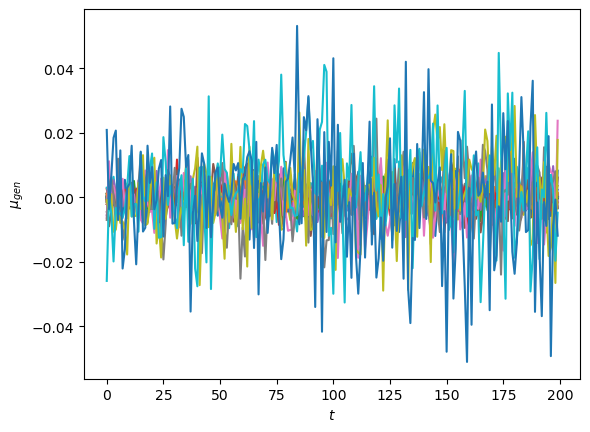

In [ ]:
for j,D in enumerate(ds_args["D"]):
    for i,a in enumerate(ds_args["alpha"]):
        k = f'{a:.3g}'+f',{D:.3g}'
        plt.plot(disp_gen[k].squeeze().mean(0), '-', c=f'C{i}',label=f'{a:.3g}, {D:.3g}'); 
    plt.xlabel(r'$t$');plt.ylabel(r'$\mu_{gen}$');

For the variance, we observe a correct reproduction of the scaling with a small deviation, as noted in the [analysis](./analysis_sbm.html#check-output-mean-and-variance).

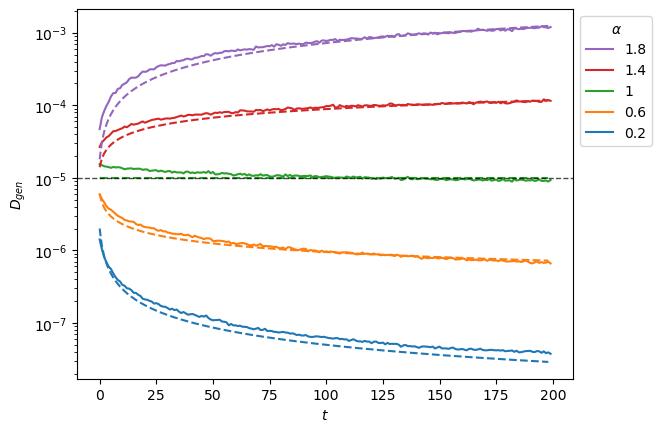

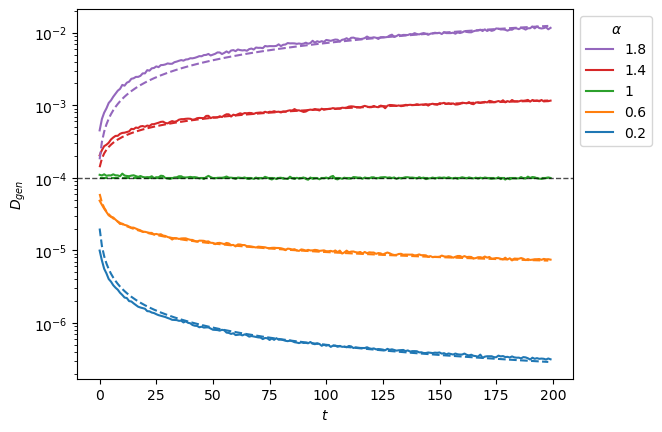

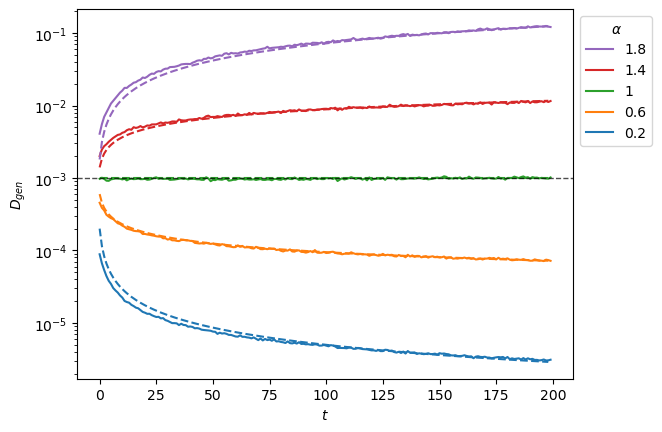

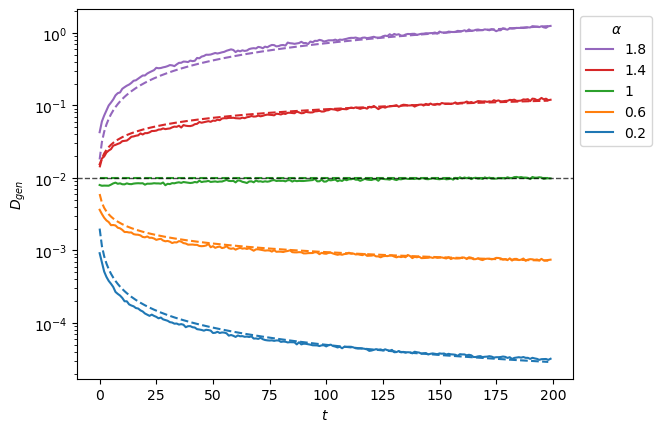

In [ ]:
for j,D in enumerate(ds_args["D"]):
    plt.figure()
    for i,a in enumerate(ds_args["alpha"][::5]):
        k = f'{a:.3g}'+f',{D:.3g}'
        # original time
        t_full = np.arange(1,disp_gen[k].shape[-1]+1)
        # shifted
        t_shift = model.receptive_field+1
        t_gen  = t_full + t_shift
        # scaling to compensate the time generated by the machine starting at RF+1
        # time scale factors: ((1+t_full)/(t_shift+t_full))**(a-1.)
        t_scaling = ((1+t_full)/(t_gen))**(a-1.)              
        x = sig2D(disp_gen[k].squeeze().std(0))
        x = x*t_scaling
        plt.semilogy(x, '-', c=f'C{i}', label=f'{a:.3g}');
        plt.plot(a*D*np.arange(1,x.shape[-1])**(a-1.), '--')
    plt.axhline(D, c='k', lw=1, ls='--', alpha=0.7);
    plt.xlabel(r'$t$');plt.ylabel(r'$D_{gen}$');
    h,l = plt.gca().get_legend_handles_labels()
    plt.legend(h[::-1],l[::-1],title=r'$\alpha$', bbox_to_anchor=(1,1));

## TEA-MSD for SBM

To extract the anomalous exponent $\alpha$ from SBM trajectories, one needs the time ensemble average mean squared displacement (TEA-MSD). As SBM is weakly non-ergodic, the TA-MSD along different time lags will not work as it did for FBM. We instead make the TA-MSD for one time lag and take the ensemble average.

In [ ]:
def TAMSD_t_lag(traj, t_lag):
    t_t_lag = len(traj) - t_lag
    tamsd = np.zeros(t_t_lag, dtype=np.float64)
    for t_ in range(t_t_lag): tamsd[t_] = (traj[t_] - traj[t_ + t_lag])**2
    tamsd /= (t_t_lag)
    return tamsd

def TEAMSD_t_lag(trajs, t_lag):
    ttt = np.zeros((trajs.shape[0], trajs.shape[-1]-t_lag), dtype=np.float64)
    for i in range(trajs.shape[0]): # prange
        ttt[i] = TAMSD_t_lag(trajs[i], t_lag)
    return ttt

def get_alphas_from_sbm_trajs(trajs, t_lag=2, perc=.55):
    tamsd_ = TEAMSD_t_lag(trajs,t_lag) # N, T-t_lag
    log_tamsd_ = np.log(tamsd_)
    # if two timesteps have the same value, tamsd_=0 and log is -inf and polyfit is nan
    log_tamsd_[~np.isfinite(log_tamsd_)]=-27
    log_t = np.log(np.arange(1,tamsd_.shape[-1]+1)) # T-t_lag
    last_perc = int(log_tamsd_.shape[-1]*perc)
    return 1.+np.polyfit(log_t[-last_perc:], log_tamsd_[:,-last_perc:].T, 1)[0]

In [ ]:
exponents = np.zeros((len(ds_args["alpha"]),len(ds_args["D"])))
for j,D in enumerate(ds_args["D"]):
    for i,a in enumerate(ds_args["alpha"]):
        k = f'{a:.3g}' + f',{D:.3g}'
        traj  = np.cumsum(disp_gen[k],-1)
        exponents[i,j] = get_alpha_from_sbm_traj(traj, t_lag=2, perc=.55)

In [ ]:
fname = '../../data/analysis/'+model_name+'_exponents.npz'
if not os.path.exists(fname):
    os.makedirs('../../data/analysis/', exist_ok=True) 
    np.savez_compressed(fname,exponents=exponents)

In [ ]:
exponents = np.load(fname)["exponents"]

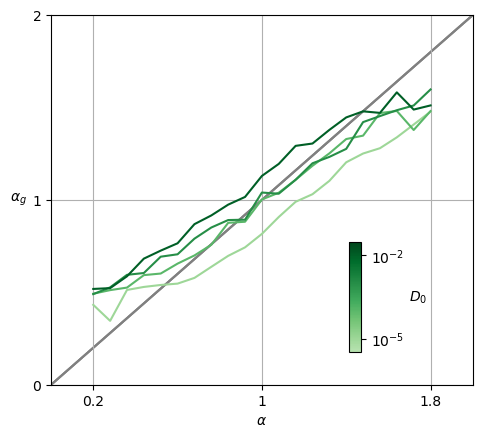

In [ ]:
cmap_D = matplotlib.colors.ListedColormap(matplotlib.colormaps['Greens'](np.linspace(0.3,1,150)))
norm_D = matplotlib.colors.LogNorm(vmin=3.16e-6, vmax=3.16e-2)
sm_D_4 = plt.cm.ScalarMappable(cmap=cmap_D, norm=norm_D)

for j,D in enumerate(ds_args["D"]):
    x = ds_args["alpha"]
    y = exponents[:,j]
    plt.plot([0,1,2], 'gray', alpha=0.7, zorder=-1);
    plt.plot(x,y, c=cmap_D(norm_D(D)),label=f'{D:.3g}');
ax = plt.gca(); ax.grid();
ax.set_xlabel(r'$\alpha$', ha='center', va='top',);
ax.set_ylabel(r'$\alpha_{g}$', rotation=0, ha='right', va='center');
ax.set_xlim(0,2); ax.set_ylim(0,2);

ax.locator_params(nbins=3);
ax.set_xticks([0.2,1,1.8],[0.2,'1',1.8])

cb = plt.colorbar(sm_D_4, ax=ax,pad=0, aspect=9,shrink=0.3, anchor=(-2,0.125));
cb.ax.set_ylabel(r'$D_0$',ha='left', va='center', rotation=0, )
cb.ax.set_yscale('log')
cb.ax.set_yticks([1e-5,1e-2], [r'$10^{-5}$',r'$10^{-2}$']);

The estimated exponent $\alpha_g$ is very close to the ground truth of the input for different values of $D_0$.